In [1]:

# We will use this cell to import all the packages you will need in the following - think of it as turning on all your systems
# in your cockpit

# This makes sure that if you change code in your external scripts, they will be updated


#import checker
#import generator

from IPython.display import display, clear_output
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

#import importlib
#importlib.reload(checker)
#importlib.reload(generator)

# now go ahead and Run the cell. This might take a while...
# while the cell is running, you will see ln[*] next to it. Once it finished, you will see the number of execution
# In case you want to interrupt the run of a cell, press Ctrl + C (on your german keyboard, this is Strg + C)

# pip install tensorflow

# There is this joke that once you have added this import line to your code,
# you are allowed to sell your product telling everyone that you are using AI. Life is easy, sometimes.

import tensorflow as tf
print('Tensorflow version:', tf.__version__, '\n')

# Keras is a model-level library, meaning that it is built upon tensorflow (using it as a backend) - allowing for
# high-level building blocks. Making it even easier to design neural networks.
# We will access it as tf.keras

# The tf and k abbreviations are best practice (same for numpy np and pandas pd),
# since you do not want to type T E N S O R F L O W all over your code.
# They are prevalent all over the industry and academia in a way that you'll risk a fight if you import them differently.



Tensorflow version: 2.14.0 



In [14]:
# Loading the MNIST dataset in one line
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Printing the shape
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

x_train_normalized = x_train/255
x_test_normalized = x_test/255

# in the next step, we also need to reshape our input to fit our input layer later on.
# This is due to keras expecting a definition for how many channels your input sample has, as we
# deal with gray scale this is 1.
x_train= x_train_normalized.reshape(-1, 28, 28, 1)
x_test = x_test_normalized.reshape(-1, 28, 28, 1)

x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)


In [33]:
train_filter = np.isin(y_train, [0, 4,9, 6])
x_train_f, y_train_f = x_train[train_filter], y_train[train_filter]

print(y_train_f)

[0 4 9 ... 9 9 6]


In [ ]:
# This is the moment where you define your model's architecture

pepsi = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28,28,1)),
    tf.keras.layers.RandomRotation(0.04),
    tf.keras.layers.RandomZoom(0.02),

    tf.keras.layers.Conv2D(filters=28, kernel_size=5, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    tf.keras.layers.Conv2D(filters=28, kernel_size=5, padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(filters=28, kernel_size=5, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Conv2D(filters=28, kernel_size=5, padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(82, kernel_regularizer = tf.keras.regularizers.l2(0.005), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GaussianNoise(0.75),

    tf.keras.layers.Dense(54, kernel_regularizer = tf.keras.regularizers.l2(0.005), activation = 'sigmoid'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GaussianNoise(0.75),
    tf.keras.layers.Dense(10, activation='softmax', use_bias=False)
   ])

pepsi.summary()

# Define your loss
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# print(-tf.math.log(1/10))

sampleID = 100
loss_fn(y_train[:1], pepsi(x_train[sampleID-1:sampleID]).numpy()).numpy()

# Compiling basically means to prepare the training routine for your model which consists of the optimizer,
# the loss, and the metrics which are to be reported during training

pepsi.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss= loss_fn,
              metrics=['accuracy'])

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_66 (RandomR  (None, 28, 28, 1)        0         
 otation)                                                        
                                                                 
 random_zoom_61 (RandomZoom)  (None, 28, 28, 1)        0         
                                                                 
 conv2d_202 (Conv2D)         (None, 28, 28, 28)        728       
                                                                 
 conv2d_203 (Conv2D)         (None, 28, 28, 28)        19600     
                                                                 
 batch_normalization_205 (Ba  (None, 28, 28, 28)       112       
 tchNormalization)                                               
                                                                 
 activation_58 (Activation)  (None, 28, 28, 28)      

In [ ]:
import datetime
import os

%load_ext tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


In [59]:
vlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 2)

checkpoint_filepath = 'tmp/model.{epoch:02d}-{val_accuracy:.4f}.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq= 'epoch'
)

history = pepsi.fit(
    np.concatenate((x_train, x_train_f[0:10000])),
    np.concatenate((y_train, y_train_f[0:10000])),
    epochs=1,
    batch_size=256,

    validation_data=(x_test, y_test),
    # callbacks=[model_checkpoint]
)
(test_loss, test_acc) = pepsi.evaluate(x_test, y_test)
print("Loss: ", test_loss)
print("Accuracy: ", test_acc)

313/313 [==============================] - 12s 38ms/step - loss: 0.0810 - accuracy: 0.9897
Loss:  0.0809696689248085
Accuracy:  0.9897000193595886


In [ ]:
# This line would start up tensorboard for you
%tensorboard --logdir logs --host localhost

In [ ]:
# after the training finishes, we will also save Marvin in Keras style (HDF5), so we do not have to
# train him again
# every time we start our computer. Obviously, by changing the model_name, you can also save different
# configurations of Marvin. The name has to be a string, like this: 'name.h5'
model_name = 'pepsi_V03e_99.6'
pepsi.save(model_name, save_format='h5')

# It is best practice to indicate what configuration changes you did within the name, so you know
# which model you need to load already from its name
# Let's say instead of a learning rate of 0.001 you used 0.1, your naming could then look like:
# 'marvin_lr01.h5'

print('Success! You saved Marvin as: ', model_name)

In [ ]:
# Plot for the intuitive approach

numbers_to_display = 196
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for plot_index in range(numbers_to_display):
    predicted_label = predictions[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens' if predicted_label == y_test[plot_index] else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(x_test_normalized[plot_index].reshape((28, 28)), cmap=color_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

In [41]:
# load a saved marvin configuration you want to evaluate
model_name = 'model.77-0.9975.h5'
pepsi_reloaded = tf.keras.models.load_model(model_name)
# pepsi = pepsi_reloaded
pepsi_reloaded = pepsi
# Let Marvin predict on the test set, so we have some data to evaluate his performance.
predictions = pepsi_reloaded.predict([x_test])
# predictions = pepsi.predict([x_test])

# Remember that the prediction of Marvin is a probability distribution over all ten-digit classes
# We want him to assign the digit class with the highest probability to the sample.
predictions = np.argmax(predictions, axis=1)
#pd.DataFrame(predictions)

313/313 [==============================] - 6s 20ms/step


313/313 [==============================] - 6s 20ms/step - loss: 0.7054 - accuracy: 0.8636
Loss:  0.70540851354599
Accuracy:  0.8636000156402588


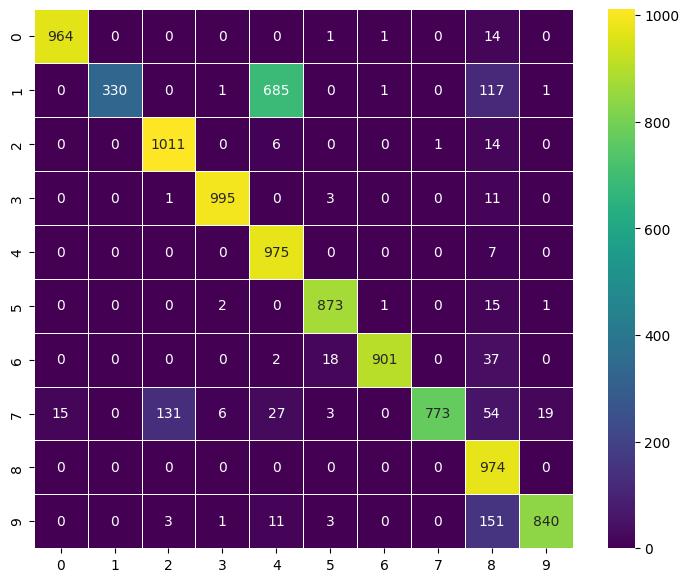

In [39]:

(test_loss, test_acc) = pepsi_reloaded.evaluate(x_test, y_test)
print("Loss: ", test_loss)
print("Accuracy: ", test_acc)

confusion_matrix = tf.math.confusion_matrix(y_test, predictions)

f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.7,
    fmt="d",
    square=True,
    ax=ax,
    cmap="viridis",
)
plt.show()